# Kidney Health EDA with Datashader & cuDF

This notebook explores the Kidney Function Health dataset using GPU-accelerated libraries.


In [1]:
import cudf
import datashader as ds
import datashader.transfer_functions as tf
from datashader.utils import export_image
import pandas as pd
import colorcet
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries loaded.")

<frozen importlib._bootstrap_external>:1301: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.
<frozen importlib._bootstrap_external>:1301: FutureWarning: The cuda.cuda module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.driver module instead.


Libraries loaded.


In [2]:
# Load Data (On GPU)
data_path = "../data/raw/kidney_dataset.csv"
try:
    df = cudf.read_csv(data_path)
    print(f"Loaded {len(df)} rows with cuDF (GPU) from CSV.")
except Exception as e:
    print(f"Error loading data: {e}")

Loaded 5000 rows with cuDF (GPU) from CSV.


## Descriptive Statistics

In [3]:
print("Dataset Description:")
print(df.describe())

Dataset Description:
        Creatinine          BUN          GFR  Urine_Output     Diabetes  \
count  5000.000000  5000.000000  5000.000000   5000.000000  5000.000000   
mean      1.994088    30.780063    73.251883   1664.302800     0.294000   
std       2.027013    31.148341    31.972399    599.384655     0.455637   
min       0.600040     7.007732     5.000000    400.502554     0.000000   
25%       0.801333    11.367599    53.036801   1105.890821     0.000000   
50%       1.007629    15.878566    89.555882   1814.499690     0.000000   
75%       2.163997    40.636666    93.989273   2146.441778     1.000000   
max       7.996428   119.931652   105.451432   2499.939696     1.000000   

       Hypertension          Age  Protein_in_Urine  Water_Intake   CKD_Status  
count   5000.000000  5000.000000       5000.000000   5000.000000  5000.000000  
mean       0.378200    50.048733        537.053851      2.504335     0.263000  
std        0.484986    14.492020        817.510451      0.86892

In [4]:
print("Missing Values:")
print(df.isnull().sum())

Missing Values:
Creatinine          0
BUN                 0
GFR                 0
Urine_Output        0
Diabetes            0
Hypertension        0
Age                 0
Protein_in_Urine    0
Water_Intake        0
Medication          0
CKD_Status          0
dtype: int64


## Classical Visualizations

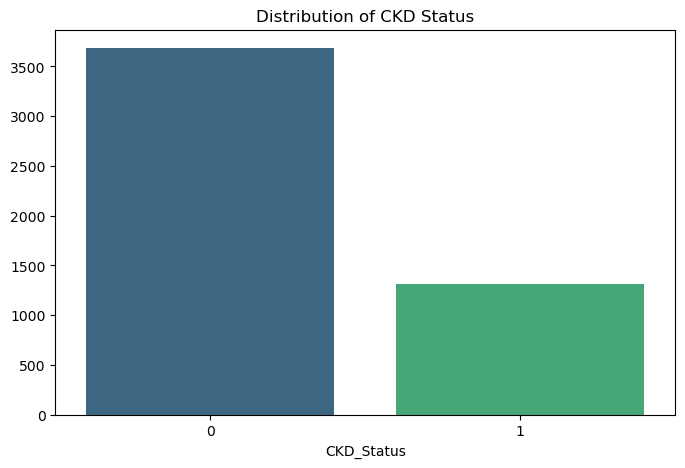

In [5]:
# Target Distribution: CKD Status
plt.figure(figsize=(8, 5))
ckd_counts = df['CKD_Status'].value_counts().to_pandas()
sns.barplot(x=ckd_counts.index, y=ckd_counts.values, palette='viridis', hue=ckd_counts.index, legend=False)
plt.title('Distribution of CKD Status')
plt.show()

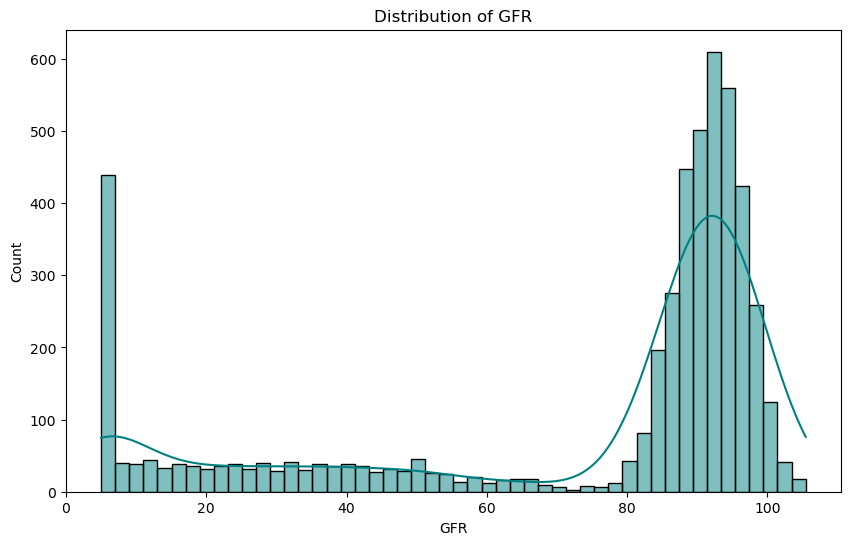

In [6]:
# Distribution of GFR
plt.figure(figsize=(10, 6))
gfr_pd = df['GFR'].to_pandas()
sns.histplot(gfr_pd, bins=50, kde=True, color='teal')
plt.title('Distribution of GFR')
plt.show()

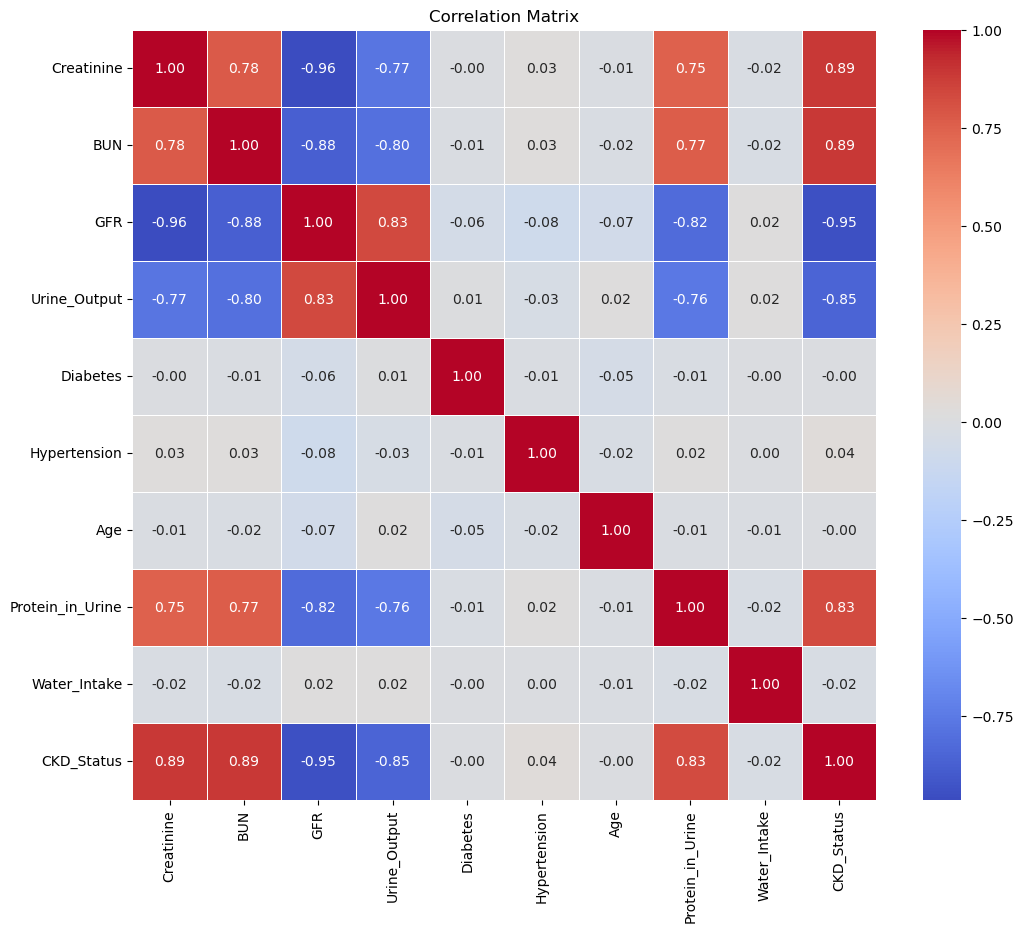

In [7]:
# Correlation Matrix (Numeric Features)
# Restore this per user request!
numeric_df = df.select_dtypes(include=['float32', 'float64', 'int32', 'int64'])
corr = numeric_df.corr().to_pandas()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

## Interactive Dashboard (hvPlot + Panel)
Use `hvplot` (based on HoloViews/Bokeh) for interactive exploration with GPU acceleration (`rasterize=True`).

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
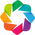

/home/thomasdigregorio/miniconda3/envs/kidney-health/lib/python3.12/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 10 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Column
    [0] Markdown(str)
    [1] Row
        [0] HoloViews(DynamicMap, height=400, sizing_mode='fixed', width=600)
        [1] HoloViews(Bars, height=400, sizing_mode='fixed', width=400)

In [8]:
import holoviews as hv
from holoviews.operation.datashader import rasterize
import panel as pn
import cupy
hv.extension('bokeh')

# --- MONKEYPATCH FOR XARRAY/CUPY COMPATIBILITY ---
# xarray expects cupy.astype() to exist, but it doesn't.
# We patch it here to use the array method instead.
if not hasattr(cupy, 'astype'):
    def _astype(x, dtype, **kwargs):
        return x.astype(dtype, **kwargs)
    cupy.astype = _astype
# -------------------------------------------------

# 1. Interactive Scatter: Age vs GFR
# Using HoloViews directly to ensure robust GPU usage
points = hv.Points(df, ['Age', 'GFR'])
scatter = rasterize(points).opts(
    cmap='fire', 
    cnorm='linear',
    width=600, height=400,
    title="Age vs GFR (Interactive GPU)"
)

# 2. Bar Chart: CKD Status
# Convert to pandas for the bar chart (small data, safe for CPU aggregation)
ckd_counts = df['CKD_Status'].value_counts().sort_index().to_pandas()
bar = hv.Bars(ckd_counts).opts(
    title="CKD Status Count", 
    color='teal',
    width=400, height=400,
    tools=['hover']
)

# 3. Compose Dashboard using Panel
dashboard = pn.Column(
    "# Kidney Health Interactive Dashboard",
    pn.Row(scatter, bar)
)

# Display inside notebook
dashboard